## Optimal statistic with discovery

In [2]:
import sys
import os
import glob

import tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [4]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [5]:
import discovery as ds

Read nanograv pulsars

In [6]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

Run with fewer pulsars

In [8]:
psrs = allpsrs[:10]

Set up GlobalLikelihood object. The GP named 'gw' will be used to build the optimal statistic; everything else will be included in individual pulsar noise. This GW object should be identical for every pulsar, and have common parameters only.

In [17]:
import importlib

importlib.reload(ds.os)
importlib.reload(ds)

<module 'discovery' from '/Users/vallis/Documents/discovery/src/discovery/__init__.py'>

In [268]:
Tspan = ds.getspan(psrs)

gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True),
                                                ds.makegp_fftcov(psr, ds.powerlaw, 61, oversample=6, T=Tspan, name='red_noise'),
                                                ds.makegp_fftcov(psr, ds.brokenpowerlaw, 61, oversample=6, T=Tspan,
                                                                 common=['gw_log10_A', 'gw_gamma', 'gw_log10_fb'], name='gw')
                                                ]) for psr in psrs])

### Basic OS

Make OS object

In [269]:
%time os = ds.OS(gbl)

CPU times: user 2.14 ms, sys: 31.2 ms, total: 33.3 ms
Wall time: 32.4 ms


Get a random set of parameters, force gamma to 13/3

In [282]:
p0 = ds.sample_uniform(os.params, priordict={'gw_(.*_)?gamma': [13/3,13/3]})

Compute the OS for the data. You get also the corresponding sigma, SNR, and the amplitude of the GW.

In [283]:
os.os(p0)

{'os': Array(-2.23750894e-32, dtype=float64),
 'os_sigma': Array(5.3711866e-32, dtype=float64),
 'snr': Array(-0.41657628, dtype=float64),
 'log10_A': -16.68645696701825}

### Alternative ORFs

The ORF takes only one parameter (the product `z = dot(pos1, pos2)`). Discovery predefines `hd_orfa`, `monopole_orfa`, `dipole_orfa`.

In [151]:
os.os(p0, ds.monopole_orfa)

{'os': Array(-1.29986081e-29, dtype=float64),
 'os_sigma': Array(5.34601231e-26, dtype=float64),
 'snr': Array(-0.00024315, dtype=float64),
 'log10_A': -11.735012908976142}

In [152]:
os.os(p0, ds.dipole_orfa)

{'os': Array(-3.63024361e-29, dtype=float64),
 'os_sigma': Array(8.89358794e-26, dtype=float64),
 'snr': Array(-0.00040819, dtype=float64),
 'log10_A': -11.735012908976142}

### "Marginalized" OS 

Create a population of parameters (normally we'd get them from an MCMC run).

In [137]:
p0s = ds.sample_uniform(os.params, priordict={'gw_(.*_)?gamma': [13/3,13/3]}, n=5)

In [139]:
p0s['B1855+09_red_noise_gamma']

array([6.37568508, 0.16135588, 4.05086831, 1.55535668, 2.3588312 ])

Then we `jax.vmap` over parameter sets

In [140]:
os_vpar = jax.vmap(os.os)

In [141]:
os_vpar(p0s)

{'log10_A': array([-12.5312213 , -17.50356974, -17.24652392, -11.31262009,
        -15.61006028]),
 'os': Array([-6.24062656e-31,  7.58635346e-31, -1.38316464e-28,  1.73267559e-30,
        -7.97481287e-31], dtype=float64),
 'os_sigma': Array([1.69509737e-28, 9.26521296e-31, 8.17114515e-32, 9.13231601e-28,
        2.30460521e-32], dtype=float64),
 'snr': Array([-3.68157409e-03,  8.18799686e-01, -1.69274271e+03,  1.89730139e-03,
        -3.46038134e+01], dtype=float64)}

### Scrambles

`os.scramble` takes as a second argument an array (or list) of pulsar positions of dimension `(npsr, 3)`

In [81]:
jnp.array(os.pos)

Array([[ 0.235276  , -0.95735312,  0.16769083],
       [ 0.38400231, -0.84770959,  0.36596539],
       [ 0.41542527, -0.76954724,  0.4849937 ],
       [ 0.98151466,  0.10005025,  0.16315308],
       [ 0.98761743,  0.1320268 ,  0.08473928],
       [ 0.42846049,  0.61411581,  0.66278457],
       [ 0.40865968,  0.75692046,  0.5099693 ],
       [ 0.23974131,  0.63501757, -0.73435467],
       [ 0.21645786,  0.96384399,  0.15540512],
       [ 0.01039278,  0.96199519,  0.27286854]], dtype=float64)

In [79]:
os.scramble(p0, jnp.array(os.pos))

{'os': Array(-5.27394604e-29, dtype=float64),
 'os_sigma': Array(5.68738967e-28, dtype=float64),
 'snr': Array(-0.09273052, dtype=float64),
 'log10_A': -13.224563963472699}

To build a background you'll want a random array of positions of dimension `(nscramble, npsr, 3)`

In [96]:
key = ds.matrix.jnpkey(42)
rpos = jax.random.normal(key, (15, len(psrs), 3))
npos = rpos / jnp.linalg.norm(rpos, axis=2)[:,:,None] # normalize vectors

Then we `jax.vmap` over positions (the second argument).

In [97]:
scramble_vpos = jax.vmap(os.scramble, (None,0))

In [99]:
scramble_vpos(p0, npos)

{'log10_A': Array([-13.22456396, -13.22456396, -13.22456396, -13.22456396,
        -13.22456396, -13.22456396, -13.22456396, -13.22456396,
        -13.22456396, -13.22456396, -13.22456396, -13.22456396,
        -13.22456396, -13.22456396, -13.22456396],      dtype=float64, weak_type=True),
 'os': Array([-4.61361936e-29, -1.53108046e-29, -1.25861586e-29,  1.01599401e-29,
         5.46241062e-29,  1.72848363e-29,  1.65206999e-29,  6.07175469e-29,
        -7.56176146e-29, -2.10386978e-29,  1.67206452e-29,  7.26641395e-29,
         9.63014747e-30,  6.02527024e-29,  2.90606473e-29], dtype=float64),
 'os_sigma': Array([9.35418117e-28, 9.55437756e-28, 5.42256692e-28, 8.11087070e-28,
        1.06316967e-27, 1.02139026e-27, 7.66377352e-28, 8.31468948e-28,
        7.64298670e-28, 6.79797936e-28, 9.59787413e-28, 9.96676216e-28,
        9.27850735e-28, 9.36542510e-28, 7.37999355e-28], dtype=float64),
 'snr': Array([-0.04932147, -0.01602491, -0.0232107 ,  0.01252632,  0.05137854,
         0.0169228

### Phase shifts

These require a diagonal Fourier GW object.

In [191]:
gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True),
                                                ds.makegp_fourier(psr, ds.brokenpowerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.brokenpowerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma', 'gw_log10_fb'], name='gw')
                                                ]) for psr in psrs])

In [192]:
os = ds.OS(gbl)

In [193]:
os.os(p0)

{'os': Array(-4.30823733e-27, dtype=float64),
 'os_sigma': Array(6.93011257e-25, dtype=float64),
 'snr': Array(-0.00621669, dtype=float64),
 'log10_A': -11.735012908976142}

`os.shift` takes as a second argument an array (or list) of pulsar positions of dimension `(npsr, nfreq)`.

Sanity check...

In [194]:
zero = jnp.zeros((len(psrs),14))
os.shift(p0, zero)

{'os': Array(-4.30823733e-27, dtype=float64),
 'os_sigma': Array(6.93011257e-25, dtype=float64),
 'snr': Array(-0.00621669, dtype=float64),
 'log10_A': -11.735012908976142}

In [195]:
key = ds.matrix.jnpkey(42)
phases = 2.0 * jnp.pi * jax.random.uniform(key, shape=(20,10,14))

Then we `jax.vmap` over phases (the second argument).

In [196]:
shift_vphase = jax.vmap(os.shift, (None,0))

In [197]:
shift_vphase(p0, phases)

{'log10_A': Array([-11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291,
        -11.73501291, -11.73501291, -11.73501291, -11.73501291],      dtype=float64, weak_type=True),
 'os': Array([ 3.33941002e-27, -7.33895271e-28,  8.43668277e-28,  6.88771478e-28,
        -4.11956898e-27, -4.53248655e-27, -1.41526412e-28,  3.27782405e-29,
         2.40576463e-27,  4.13801015e-28,  1.67877729e-27,  7.12885800e-28,
        -2.09995848e-28, -4.57350093e-28, -3.42784005e-27,  4.21363613e-27,
        -1.01422436e-27,  2.77293787e-27, -4.00326034e-28,  1.39401202e-27],      dtype=float64),
 'os_sigma': Array([6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e-25,
        6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e-25,
        6.93011257e-25, 6.93011257e-25, 6.93011257e-25, 6.93011257e

### Plotting correlation coefficients

Build a NANOGrav 15-yr model using all the pulsars.

In [466]:
gbl = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                                ds.makenoise_measurement(psr, psr.noisedict),
                                                ds.makegp_ecorr(psr, psr.noisedict),
                                                ds.makegp_timing(psr, svd=True),
                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=Tspan, name='red_noise'),
                                                ds.makegp_fourier(psr, ds.powerlaw, 14, T=Tspan,
                                                                  common=['gw_log10_A', 'gw_gamma'], name='gw')
                                                ]) for psr in allpsrs])

In [467]:
os = ds.OS(gbl)

Get the MAP parameter set from an actual MCMC run on 15-yr NANOGrav data

In [313]:
df = pd.read_feather('../data/NG15yr-m2a-chain.feather')

In [469]:
p0 = df.iloc[df['logp'].argmax()].to_dict()

Sanity check

In [471]:
os.os(p0)

{'os': Array(4.79414854e-29, dtype=float64),
 'os_sigma': Array(9.4426185e-30, dtype=float64),
 'snr': Array(5.07713886, dtype=float64),
 'log10_A': -14.186517715454102}

Simple minded correlation plot: get angles and bin the data

In [482]:
def oscorr(os, p0, nbins=10):
    iota = np.arccos(jnp.array(os.angles)) * (180 / np.pi)

    bins = np.linspace(0, 180, nbins + 1)
    indices = np.digitize(iota, bins) - 1
    masks = [np.where(indices == i)[0] for i in range(nbins)]

    # orfs = ds.hd_orfa(np.array(os.angles))
    orfs = np.ones_like(os.angles)

    rhos, sigmas = os.os_rhosigma(p0)
    gwnorm = 10**(2.0 * p0[os.gwpar])
    rhos, sigmas = gwnorm * rhos, gwnorm * sigmas
    
    iotas = [np.mean(iota[mask]) for mask in masks]
    oses = [np.sum(rhos[mask] * orfs[mask] / sigmas[mask]**2) / np.sum(orfs[mask]**2 / sigmas[mask]**2)
            for mask in masks]
    osigs = [1 / np.sqrt(np.sum(orfs[mask]**2 / sigmas[mask]**2))
           for mask in masks]

    return iotas, oses, osigs

In [483]:
iotas, oses, osigs = oscorr(os, p0)

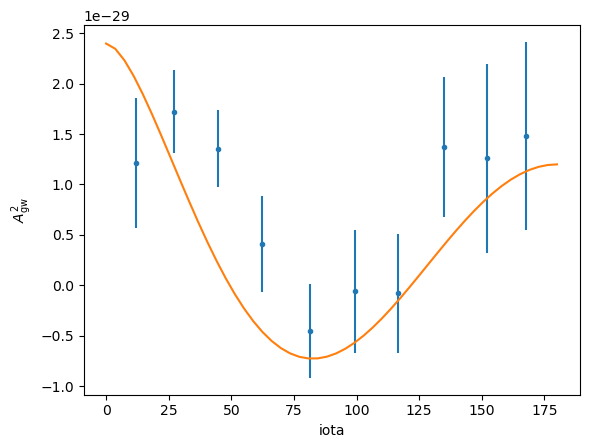

In [503]:
pp.errorbar(iotas, oses, yerr=osigs, fmt='.')

a = np.linspace(1e-6, 180)
hd = os.os(p0)['os'] * ds.hd_orfa(np.cos(a * (np.pi/180.0)))

pp.plot(a, hd)
pp.xlabel('iota'); pp.ylabel(r'$A_\mathrm{gw}^2$');